In [1]:
import torch
import torch.nn as nn
from torchvision.utils import make_grid

from model import ResNet50Encoder
from dataset import build_dataset
from nce import nce_retrieval
from caption_encoder import CaptionEncoder
import mixed_precision

SEQ_LEN = 20
N_RKHS = 1024

device = 'cuda' if tor
if device == 'cuda':
    mixed_precision.enable_mixed_precision()

I1127 09:50:58.572285 140599522494272 file_utils.py:39] PyTorch version 1.1.0 available.
W1127 09:50:58.708591 140599522494272 __init__.py:28] To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html


In [2]:
caption_encoder = CaptionEncoder(N_RKHS, SEQ_LEN, device=device, hidden_size=4096)
resnet50 = ResNet50Encoder(encoder_size=128, n_rkhs=N_RKHS, ndf=128 )
resnet50.to(device)
resnet50, _ = mixed_precision.initialize(resnet50, None)

ckpt = torch.load('checkpoints/ck4lxlpp_model.pth')
resnet50.load_state_dict(ckpt['resnet50'])
caption_encoder.fc.load_state_dict(ckpt['caption_fc'])
print('Checkpoint loaded.')


I1127 09:50:58.905358 140599522494272 tokenization_utils.py:374] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/wibuch/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I1127 09:50:59.187022 140599522494272 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-config.json from cache at /home/wibuch/.cache/torch/transformers/a41e817d5c0743e29e86ff85edc8c257e61bc8d88e4271bb1b243b6e7614c633.1ccd1a11c9ff276830e114ea477ea2407100f4a3be7bdc45d37be9e37fa71c7e
I1127 09:50:59.190913 140599522494272 configuration_utils.py:168] Model config {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "n_heads": 12,
 

Using a 128x128 encoder
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Checkpoint loaded.


In [3]:
import os
from torchvision import datasets, transforms

batch_size = 2000
INTERP = 3

class VizTransforms:
    '''
    ImageNet dataset, for use with 128x128 full image encoder.
    '''
    def __init__(self):
        post_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.test_transform = transforms.Compose([
            transforms.Resize(146, interpolation=INTERP),
            transforms.CenterCrop(128),
            post_transform
        ])

        self.raw_trans = transforms.Compose([
            transforms.Resize(256, interpolation=INTERP),
            transforms.CenterCrop(256),
            transforms.ToTensor()
        ])
        
    
    def __call__(self, inp):
        out = self.test_transform(inp)
        raw = self.raw_trans(inp)
        return out, raw

transforms128 = VizTransforms()
test_dataset = datasets.CocoCaptions(
                    root=os.path.expanduser('~/data/coco/val2017'), 
                    annFile=os.path.expanduser('~/data/coco/annotations/captions_val2017.json'), 
                    transform=transforms128)

loader = \
    torch.utils.data.DataLoader(dataset=test_dataset,
                                batch_size=batch_size,
                                shuffle=True,
                                pin_memory=True,
                                drop_last=True,
                                num_workers=16)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [4]:
(transformed_imgs, raw_imgs), captions = next(iter(loader))
transformed_imgs = transformed_imgs.to(device)
encoded_imgs = resnet50(transformed_imgs)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
%matplotlib inline

def nce_retrieval_reverse(encoded_images, encoded_queries, top_k=5):
    batch_size = encoded_images.size(0)
    n_rkhs = encoded_images.size(1)
    n_queries = encoded_queries.size(0)

    # (bs, 1, 1, rkhs) -> (bs, rkhs)
    encoded_images = encoded_images.reshape(batch_size, n_rkhs)
    encoded_images = F.normalize(encoded_images)

    scores = torch.mm(encoded_images, encoded_queries.t())
    cos_sims_idx = torch.sort(scores, dim=1, descending=True)[1]
    cos_sis_idx = cos_sims_idx[:, :top_k]
    return cos_sis_idx

def show(img):
    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(30, 60))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def visualize(encoded_queries, encoded_imgs, raw_imgs):    
    top_k = 5
    top_k_idx = nce_retrieval(encoded_imgs, encoded_queries, top_k)
    top_k_idx = torch.flatten(top_k_idx)
    matches = raw_imgs[top_k_idx]
    viz = make_grid(matches, nrow=top_k)
    show(viz.cpu()) 

def visualize_captions(raw_captions, encoded_queries, encoded_imgs, raw_imgs):
    viz = make_grid(raw_imgs, nrow=raw_imgs.size(0))
    show(viz.cpu()) 
    top_k = 5
    top_k_idx = nce_retrieval_reverse(encoded_imgs, encoded_queries, top_k)
    for i, e in enumerate(top_k_idx):
        print('\n'.join([raw_captions[idx] for idx in e]))
        print('-----------')

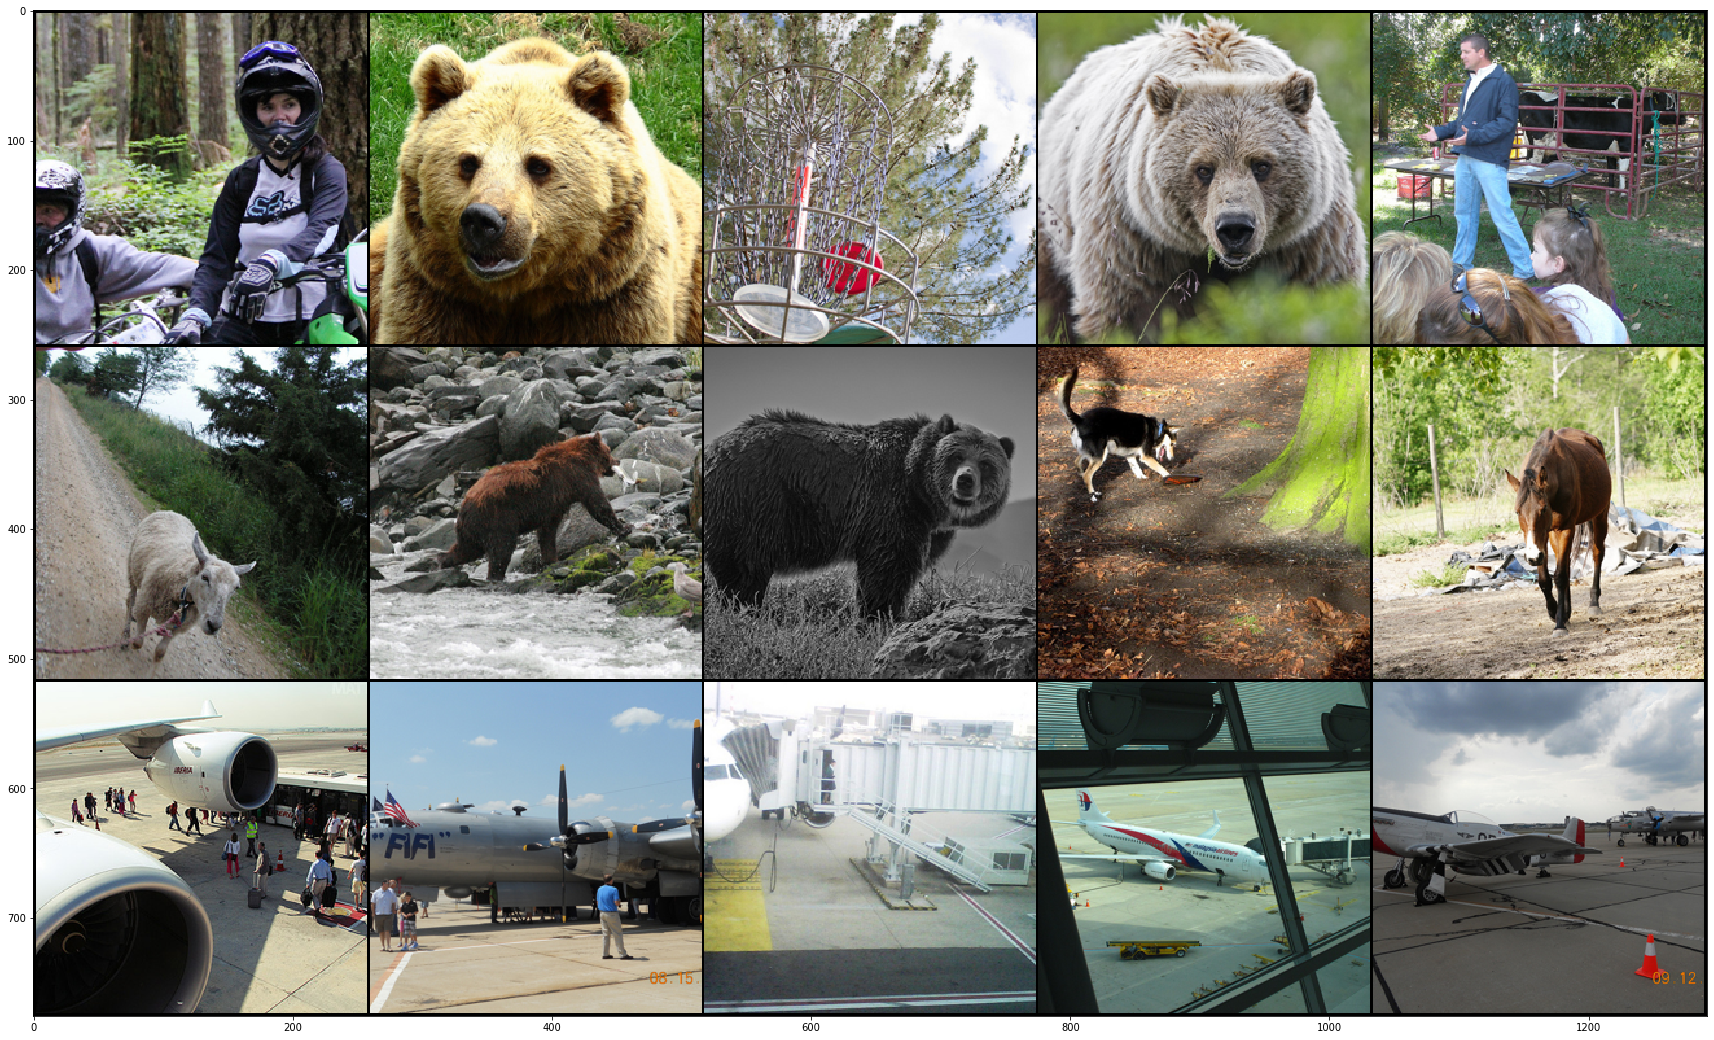

In [14]:
# Caption -> Image retrival
queries = [
    'Someone playing the guitar.'
    'A big bear in the woods.',
    'A moose walking on the grass.',
    'A man is standing next to an airplane.'
]
encoded_queries, _ = caption_encoder(queries)
visualize(encoded_queries, encoded_imgs, raw_imgs) 

The little  girl is eating a banana.

A man and young girl surrounded by various fruits.
A little boy wearing a red shirt holding a white frisbee.
A hand is holding a carrot for a llama to chew. 
A person holding a bit vegetable in their left hand.
-----------
A large living room with leather couches and wood flooring
A living room with hard wood flooring and black furniture.
A spacious living room with three windows and a wooden floor.
A living room filled with furniture and a book shelf filled with books.
A very nice living room that is very clean.
-----------
Two twin beds pushed together with white blankets and pillows on top of them.
A bed in a ten with a colorful ceiling.
The bed and desk in a modern hotel room
A large bed with two lamps on either side lighting the room. 
A scene of an apartment with a dining table and a couple of couches.
-----------
A man plays tennis during a competition while a crowd looks on. 
A tennis player hits a high ball in front of an audience. 
A man 

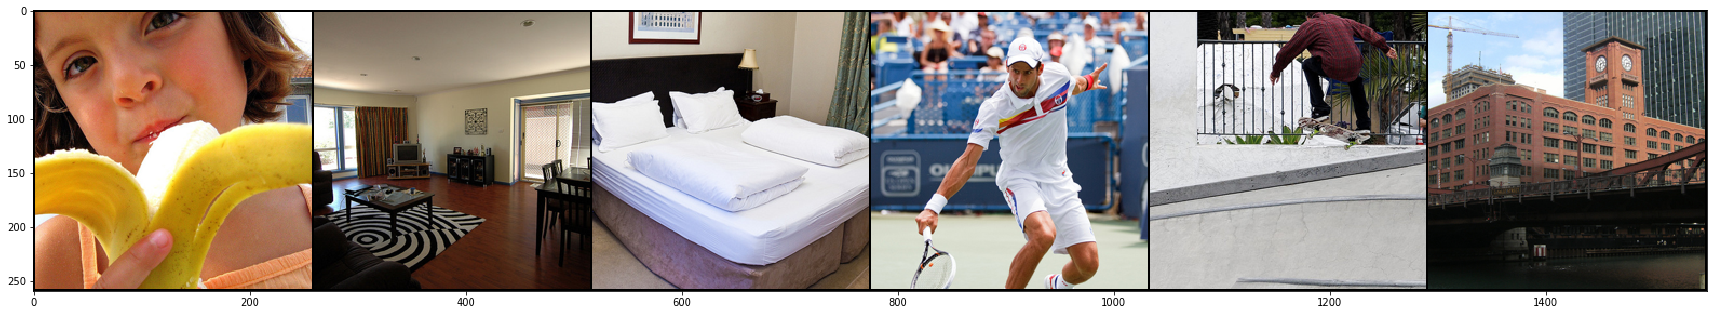

In [17]:
# Image -> Caption retrieval
encoded_queries, _ = caption_encoder(captions[0])
visualize_captions(captions[0], encoded_queries, encoded_imgs[18:24], raw_imgs[18:24])    